In [13]:

import pandas as pd
import numpy as np
import NDCG as ndcg
import MHR as mhr
import sys
import types
ndcg.reload_package(mhr)
from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
%matplotlib inline

loading MHR


In [14]:
def pr_hs(r): 
    try:
        return ( 1 / r['pageRank'] ) + ( 1 / r['hits'] )
    except:
        return 0

def pr_len(r): 
    try:
        return ( 1 / r['pageRank'] ) + ( 1 / r['word_count'] )
    except:
        return 0
    
def hs_len(r): 
    try:
        return ( 1 / r['hits'] ) + ( 1 / r['word_count'] )
    except:
        return 0

def pr_hs_len(r): 
    try:
        return ( 1 / r['pr_hs'] ) + ( 1 / r['hs_len'] )
    except:
        return 0

def word_count(r): 
    try:
        return len(tokenizer.tokenize(r["reviewText"]))
    except:
        return 0

In [15]:
reviews_features = pd.read_csv('data/book_eletronic_sample_counts.csv.gz')
reviews_features = reviews_features[reviews_features.pageRank>0]
print (reviews_features.shape)
df_columns = reviews_features.select_dtypes(include=['float64','int','int64']).columns
df_columns

(24234, 32)


Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1', u'Unnamed: 0.1.1',
       u'Unnamed: 0.1.1', u'Unnamed: 0.1.1.1', u'Unnamed: 0.1.1.1', u'overall',
       u'unixReviewTime', u'helpfulness', u'tot', u'pageRank', u'hits',
       u'powerWithStar', u'word_count', u'pr_hs', u'pr_len', u'hs_len',
       u'pr_hs_len', u'sentence_count', u'unigram_count', u'adj', u'noun',
       u'revRank'],
      dtype='object')

In [16]:
reviews_features['word_count']=reviews_features.apply(word_count,axis=1)
reviews_features['pr_hs']=reviews_features.apply(pr_hs,axis=1)
reviews_features['pr_len']=reviews_features.apply(pr_len,axis=1)
reviews_features['hs_len']=reviews_features.apply(hs_len,axis=1)
reviews_features['pr_hs_len']=reviews_features.apply(pr_hs_len,axis=1)
#reviews_features.to_csv('data/book_sample.csv.gz', compression='gzip')
reviews_features.shape

(24234, 32)

In [17]:
def helpf(x):
    x = str(x['helpful']) 
    try:
        pos = x.replace("[","").replace("]","").split(',')[0]
        neg = x.replace("[","").replace("]","").split(',')[1]
        tot = x.replace("[","").replace("]","").split(',')[1]
        return float ( float(pos) /  float(tot) )
    except:
        return 0

def tot(x): 
    x = str(x['helpful'])
    #print x.replace("[","").replace("]","").split(',')[1]
    try:
        return int(x.replace("[","").replace("]","").split(', ')[1])
    except:
        return 0



reviews_features['helpfulness']=reviews_features.apply(helpf,axis=1)
reviews_features['tot']=reviews_features.apply(tot,axis=1)

reviews_features,ndcg_mrr_1 = mhr.executeFromDf(reviews_features, 0.9, -0.12, 1)
reviews_features,ndcg_mrr_3 = mhr.executeFromDf(reviews_features, 0.9, -0.12, 3)
reviews_features,ndcg_mrr_5 = mhr.executeFromDf(reviews_features, 0.9, -0.12, 5)

product=0002051850 ndcg=1.0 (1.0)
product=000224053X ndcg=0.890625 (0.78125)
product=0006393195 ndcg=0.872537878788 (0.836363636364)
product=0006530702 ndcg=0.875093064263 (0.88275862069)
product=0007157150 ndcg=0.880074451411 (0.9)
product=0007167040 ndcg=0.858395376176 (0.75)
product=000721278X ndcg=0.859643589169 (0.867132867133)
product=0007228023 ndcg=0.845938140523 (0.75)
product=0007231601 ndcg=0.849167236021 (0.875)
product=000779021X ndcg=0.830917179085 (0.666666666667)
product=0026045702 ndcg=0.823561071896 (0.75)
product=0029109752 ndcg=0.834772879804 (0.958102766798)
product=006000942X ndcg=0.836493647292 (0.857142857143)
product=0060083816 ndcg=0.838320455737 (0.862068965517)
product=0060084332 ndcg=0.84289126476 (0.906882591093)
product=0060175869 ndcg=0.848645520062 (0.934959349593)
product=0060192119 ndcg=0.852201131182 (0.909090909091)
product=006019491X ndcg=0.829547981919 (0.444444444444)
product=0060393491 ndcg=0.828772552071 (0.814814814815)
product=0060508205 ndcg

In [18]:
np.mean(ndcg_mrr_5)

0.80716872550762186

pr_hs_len ndcg=0.77131406432
MHR ndcg=0.807168725508
RevRank ndcg=0.687225066461
461
461
461


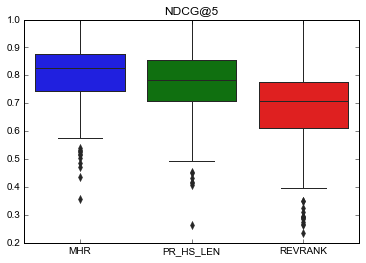

In [19]:
import seaborn as sns
k=5

ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',k) 
corr_pr_hs_len=ndcg.calc_corr(reviews_features,'pr_hs_len') 
print ("pr_hs_len ndcg="+str(np.mean(ndcg_pr_hs_len)))

#ndcg_mhr=ndcg.calc_ndcg(reviews_features,'powerWithStar',k) 
corr_mhr=ndcg.calc_corr(reviews_features,'powerWithStar') 
print ("MHR ndcg="+str(np.mean(ndcg_mrr_5)))

ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',k) 
corr_revRank=ndcg.calc_corr(reviews_features,'revRank') 
print ("RevRank ndcg="+str(np.mean(ndcg_revRank)))

print (len(ndcg_pr_hs_len))
print (len(ndcg_mrr_5))
print (len(ndcg_revRank))

tip={}
tip['PR_HS_LEN']=ndcg_pr_hs_len
tip['MHR']=ndcg_mrr_5
tip['REVRANK']=ndcg_revRank
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
#ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))

In [20]:
ndcg_pr_hs_len1=ndcg.calc_ndcg(reviews_features,'pr_hs_len',1) 
print("pr_hs_len ndcg 1="+str(np.mean(ndcg_pr_hs_len1)))
ndcg_pr_hs_len3=ndcg.calc_ndcg(reviews_features,'pr_hs_len',3) 
print( "pr_hs_len ndcg 3="+str(np.mean(ndcg_pr_hs_len3)))
ndcg_pr_hs_len5=ndcg.calc_ndcg(reviews_features,'pr_hs_len',5) 
print("pr_hs_len ndcg 5="+str(np.mean(ndcg_pr_hs_len5)))

pr_hs_len ndcg 1=0.726896292723
pr_hs_len ndcg 3=0.756294836225
pr_hs_len ndcg 5=0.77131406432


In [21]:
ndcg_revRank1=ndcg.calc_ndcg(reviews_features,'revRank',1) 
print("revRank ndcg 1="+str(np.mean(ndcg_revRank1)))
ndcg_revRank3=ndcg.calc_ndcg(reviews_features,'revRank',3) 
print("revRank ndcg 3="+str(np.mean(ndcg_revRank3)))
ndcg_revRank5=ndcg.calc_ndcg(reviews_features,'revRank',5) 
print( "revRank ndcg 5="+str(np.mean(ndcg_revRank5)))

revRank ndcg 1=0.66052590951
revRank ndcg 3=0.681738097775
revRank ndcg 5=0.687225066461


In [22]:
ndcg_mhr1=ndcg.calc_ndcg(reviews_features,'powerWithStar',1) 
print("MRR ndcg 1="+str(np.mean(ndcg_mhr1)))
ndcg_mhr3=ndcg.calc_ndcg(reviews_features,'powerWithStar',3) 
print("MRR ndcg 3="+str(np.mean(ndcg_mhr3)))
ndcg_mhr5=ndcg.calc_ndcg(reviews_features,'powerWithStar',5) 
print( "MRR ndcg 5="+str(np.mean(ndcg_mhr5)))

MRR ndcg 1=0.756376488673
MRR ndcg 3=0.758378765297
MRR ndcg 5=0.764850370217


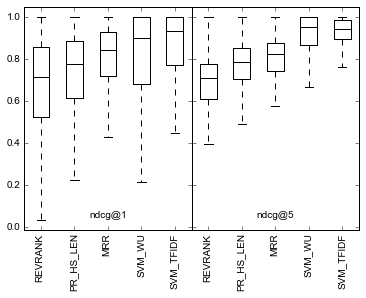

In [ ]:
ndcg_1_svm= np.array(pd.read_csv('data/ndcg_1_svm_books_revisited.csv').values.tolist())[:,1]
ndcg_3_svm= np.array(pd.read_csv('data/ndcg_3_svm_books_revisited.csv').values.tolist())[:,1]
ndcg_5_svm= np.array(pd.read_csv('data/ndcg_5_svm_books_revisited.csv').values.tolist())[:,1]

ndcg_1_svm_wu= np.array(pd.read_csv('data/ndcg_1_svm_books.csv').values.tolist())[:,1]
ndcg_3_svm_wu= np.array(pd.read_csv('data/ndcg_3_svm_books.csv').values.tolist())[:,1]
ndcg_5_svm_wu= np.array(pd.read_csv('data/ndcg_5_svm_books.csv').values.tolist())[:,1]

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt 
%matplotlib inline
data_to_plot = [ndcg_revRank1, ndcg_pr_hs_len1, ndcg_mrr_1, ndcg_revRank3, ndcg_pr_hs_len3, ndcg_mrr_3, ndcg_revRank5, ndcg_pr_hs_len5, ndcg_mrr_5]


#bp = plt.boxplot(data_to_plot, labels=["R@1","P@1","M@1","R@3","P@3","M@3","R@5","P@5","M@5"], sym='')


#fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
fig, (ax1, ax3) = plt.subplots(ncols=2, sharey=True)
fig.subplots_adjust(wspace=0)

data={}
data['ndcg@1']=[ndcg_revRank1, ndcg_pr_hs_len1, ndcg_mrr_1, ndcg_1_svm_wu, ndcg_1_svm]
#data['ndcg@3']=[ndcg_revRank3, ndcg_pr_hs_len3, ndcg_mrr_3, ndcg_3_svm_wu, ndcg_3_svm]
data['ndcg@5']=[ndcg_revRank5, ndcg_pr_hs_len5, ndcg_mrr_5, ndcg_5_svm_wu, ndcg_5_svm]
#for ax, name in zip(axes, ['ndcg@1', 'ndcg@3', 'ndcg@5']):
#    ax.boxplot(data[name])
#    ax.set(xticklabels=['revRank', 'pr_hs_len', 'MRR'], xlabel=name)
#    ax.margins(0.05) # Optional
    
bp1=ax1.boxplot(data['ndcg@1'],sym='')

ax1.set(xticklabels=['REVRANK', 'PR_HS_LEN', 'MRR', 'SVM_WU', 'SVM_TFIDF'], xlabel='ndcg@1')
ax1.XTickLabelRotation=45
ax1.margins(0.5) # Optional
plt.setp(bp1['boxes'], linewidth=1, color='black')
plt.setp(bp1['fliers'], linewidth=1, color='black')
plt.setp(bp1['medians'], linewidth=1, color='black')
plt.setp(bp1['whiskers'], linewidth=1, color='black')

for i in range(3):
    med = bp1['medians'][i]
    #ax1.plot([np.mean(med.get_xdata())], [np.mean(data['ndcg@1'][i])], color='k', marker='*', markeredgecolor='k')




#bp2=ax2.boxplot(data['ndcg@3'],sym='')
#ax2.set(xticklabels=['REVRANK', 'PR_HS_LEN', 'MRR', 'SVM_WU', 'SVM_TFIDF'], xlabel='ndcg@3')
#ax2.margins(0.05) # Optional
#plt.setp(bp2['boxes'], linewidth=1, color='black')
#plt.setp(bp2['fliers'], linewidth=1, color='black')
#plt.setp(bp2['medians'], linewidth=1, color='black')
#plt.setp(bp2['whiskers'], linewidth=1, color='black')
#for i in range(3):
#    med = bp2['medians'][i]
    #ax2.plot([np.mean(med.get_xdata())], [np.mean(data['ndcg@3'][i])], color='k', marker='*', markeredgecolor='k')





bp3=ax3.boxplot(data['ndcg@5'],sym='')
ax3.set(xticklabels=['REVRANK', 'PR_HS_LEN', 'MRR', 'SVM_WU', 'SVM_TFIDF'], xlabel='ndcg@5')
ax3.margins(0.05) # Optional
plt.setp(bp3['boxes'], linewidth=1, color='black')
plt.setp(bp3['fliers'], linewidth=1, color='black')
plt.setp(bp3['medians'], linewidth=1, color='black')
plt.setp(bp3['whiskers'], linewidth=1, color='black')

for i in range(3):
    med = bp3['medians'][i]
    #ax3.plot([np.mean(med.get_xdata())], [np.mean(data['ndcg@5'][i])], color='k', marker='*', markeredgecolor='k')





ax1.xaxis.labelpad = -80
#ax2.xaxis.labelpad = -80
ax3.xaxis.labelpad = -80



for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

    
# plt.figtext(0.80, 0.5, '*', color='k', backgroundcolor='gray',
#             weight='roman', size='medium')
# plt.figtext(0.815, 0.5, ' Mean Value', color='black', weight='roman',
#             size='medium', backgroundcolor='gray',)
    
plt.show()


In [28]:
from scipy.stats import mstats
import scipy as scipy

print "###parametric test."
print "ndcg@1"
print "mrr=svm_TFIDF? p="+ str(scipy.stats.ttest_ind(ndcg_mrr_1, ndcg_1_svm))
print "mrr=svm_WU? p="+ str(scipy.stats.ttest_ind(ndcg_mrr_1, ndcg_1_svm_wu))
print "mrr=ndcg_pr_hs_len? p="+ str(scipy.stats.ttest_ind(ndcg_mrr_1, ndcg_pr_hs_len1))
print "svm=ndcg_pr_hs_len? p="+ str(scipy.stats.ttest_ind(ndcg_1_svm, ndcg_pr_hs_len1))

# print "ndcg@3"
# print "mrr=svm? p="+ str(scipy.stats.ttest_ind(ndcg_mrr_3, ndcg_3_svm))
# print "mrr=ndcg_pr_hs_len? p="+ str(scipy.stats.ttest_ind(ndcg_mrr_3, ndcg_pr_hs_len3))
# print "svm=ndcg_pr_hs_len? p="+ str(scipy.stats.ttest_ind(ndcg_3_svm, ndcg_pr_hs_len3))

print "ndcg@5"
print "mrr=svm? p="+ str(scipy.stats.ttest_ind(ndcg_mrr_5, ndcg_5_svm))
print "mrr=ndcg_pr_hs_len? p="+ str(scipy.stats.ttest_ind(ndcg_mrr_5, ndcg_pr_hs_len5))
print "svm=ndcg_pr_hs_len? p="+ str(scipy.stats.ttest_ind(ndcg_5_svm, ndcg_pr_hs_len5))

###parametric test.
ndcg@1
mrr=svm_TFIDF? p=Ttest_indResult(statistic=-4.871710080959204, pvalue=1.3024793172487546e-06)
mrr=svm_WU? p=Ttest_indResult(statistic=-0.81945514266305353, pvalue=0.41274017511391736)
mrr=ndcg_pr_hs_len? p=Ttest_indResult(statistic=5.2900979819145268, pvalue=1.5284810143649314e-07)
svm=ndcg_pr_hs_len? p=Ttest_indResult(statistic=9.7972479188829187, pvalue=1.267527283079873e-21)
ndcg@5
mrr=svm? p=Ttest_indResult(statistic=-21.89519403861161, pvalue=7.5447015744995457e-86)
mrr=ndcg_pr_hs_len? p=Ttest_indResult(statistic=5.0403895637027487, pvalue=5.593565501887662e-07)
svm=ndcg_pr_hs_len? p=Ttest_indResult(statistic=25.986551633577594, pvalue=4.6611621280689302e-112)
